In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

In [2]:
# Define the path to the dataset
base_dir = r"D:\downloads\archive\Combined_Dataset\train"

# Define class names
class_names = ["Mild_Impairment", "Moderate_Impairment", "No_Impairment", "Very_Mild_Impairment"]

In [3]:
# Function to load a single image
def load_image(file_path, target_size):
    """Load and preprocess an image using Pillow."""
    img = Image.open(file_path).convert('L')  # Convert to grayscale
    img = img.resize(target_size)  # Resize to target size
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    return img_array


In [4]:
# Load the dataset
def load_dataset(base_dir, class_names, target_size):
    """Load all images and labels from the dataset directory."""
    data = []
    labels = []
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Directory not found: {class_dir}")
            continue
        print(f"Loading images from: {class_dir}")
        for file in os.listdir(class_dir):
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                file_path = os.path.join(class_dir, file)
                try:
                    img = load_image(file_path, target_size)
                    data.append(img)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")
    return np.array(data), np.array(labels)

In [5]:
# Target size for resizing images
target_size = (128, 128)

# Load training data
X, y = load_dataset(base_dir, class_names, target_size)

# Debugging: Check if data is loaded
if len(X) == 0:
    print("No images loaded. Please check the dataset.")
else:
    print(f"Loaded {len(X)} images.")

Loading images from: D:\downloads\archive\Combined_Dataset\train\Mild_Impairment


Loading images from: D:\downloads\archive\Combined_Dataset\train\Moderate_Impairment
Loading images from: D:\downloads\archive\Combined_Dataset\train\No_Impairment
Loading images from: D:\downloads\archive\Combined_Dataset\train\Very_Mild_Impairment
Loaded 10240 images.


In [6]:
# Ensure data shape is consistent
X = X[..., np.newaxis]  # Add channel dimension for grayscale images

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=len(class_names))

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Debugging: Check shapes
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

Training data shape: (8192, 128, 128, 1), Validation data shape: (2048, 128, 128, 1)


In [7]:
# Build a 2D CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# Save the model
model.save("mri_classification_model.h5")
print("Model training complete and saved as mri_classification_model.h5")


d:\python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 64s 118ms/step - accuracy: 0.4921 - loss: 1.1370 - val_accuracy: 0.7769 - val_loss: 0.5005
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 61s 120ms/step - accuracy: 0.7878 - loss: 0.4871 - val_accuracy: 0.8804 - val_loss: 0.3003
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 69s 135ms/step - accuracy: 0.8462 - loss: 0.3626 - val_accuracy: 0.9004 - val_loss: 0.2389
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 69s 135ms/step - accuracy: 0.8798 - loss: 0.2897 - val_accuracy: 0.9346 - val_loss: 0.1748
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 65s 127ms/step - accuracy: 0.9125 - loss: 0.2209 - val_accuracy: 0.9521 - val_loss: 0.1292
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 60s 117ms/step - accuracy: 0.9300 - loss: 0.1754 - val_accuracy: 0.9385 - val_loss: 0.1470
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 61s 120ms/step - accuracy: 0.9421 - loss: 0.1384 - val_accuracy: 0.9707 - val_loss: 0.0869
Epoch 8/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 61s 120ms/step - accuracy: 0.9537 - loss: 0

Model training complete and saved as mri_classification_model.h5


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict on validation data
y_pred_probs = model.predict(X_val)  # Get class probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_classes = np.argmax(y_val, axis=1)  # Convert one-hot encoding back to labels

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


In [15]:
from sklearn.metrics import matthews_corrcoef

# Compute MCC
mcc = matthews_corrcoef(y_true_classes, y_pred_classes)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


Matthews Correlation Coefficient (MCC): 0.9812


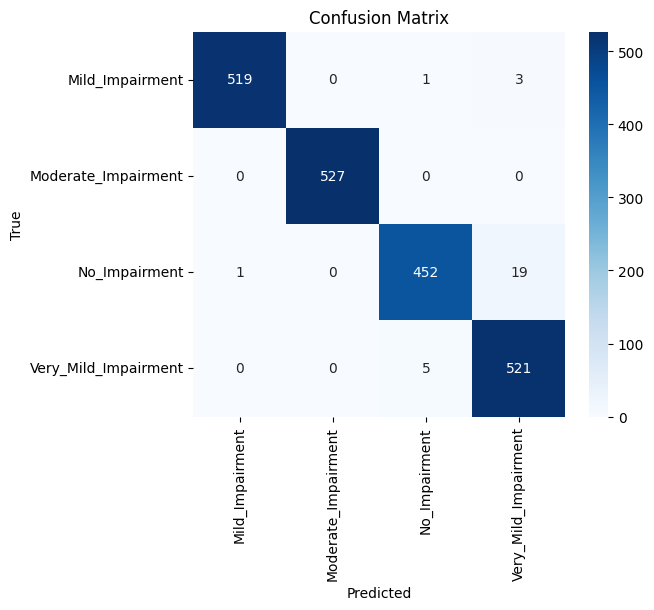

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [17]:
from sklearn.metrics import precision_recall_fscore_support

# Compute Precision, Recall, and F1-score (macro average)
precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average="macro")

print(f"Precision (Macro-Average): {precision:.4f}")
print(f"Recall (Macro-Average): {recall:.4f}")
print(f"F1-Score (Macro-Average): {f1:.4f}")


Precision (Macro-Average): 0.9861
Recall (Macro-Average): 0.9851
F1-Score (Macro-Average): 0.9855


In [ ]:
from sklearn.metrics import roc_auc_score

# Compute ROC-AUC Score (One-vs-Rest for multi-class classification)
roc_auc = roc_auc_score(y_val, y_pred_probs, multi_class="ovr")

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9990


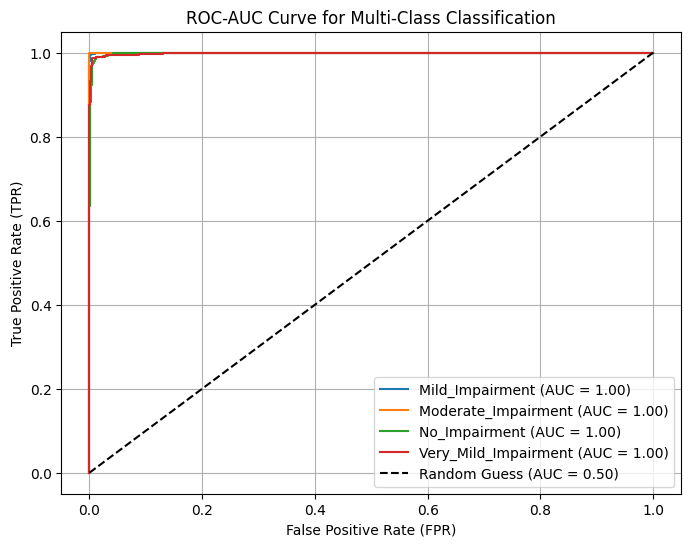

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plot ROC Curves for each class
plt.figure(figsize=(8, 6))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred_probs[:, i])  # Compute FPR & TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

# Plot reference line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")

# Labels & Title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-AUC Curve for Multi-Class Classification")
plt.legend()
plt.grid()
plt.show()
